In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf

In [2]:
df_train=pd.read_csv("mitbih_train.csv",header=None)
df_test=pd.read_csv("mitbih_test.csv",header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
df_train[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

## Visulazing the training dataset

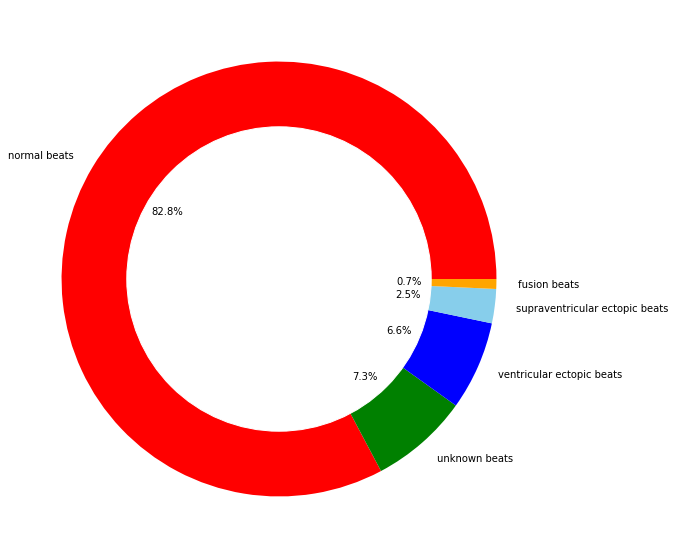

In [4]:
per_class=df_train[187].value_counts()
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beats','unknown beats','ventricular ectopic beats','supraventricular ectopic beats',
                           'fusion beats'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Resample 20000 normal beats because they are the majority in the dataset

In [5]:
from sklearn.utils import resample

d1=df_train[df_train[187]==1]
d2=df_train[df_train[187]==2]
d3=df_train[df_train[187]==3]
d4=df_train[df_train[187]==4]

d0=df_train[df_train[187]==0].sample(n=20000,random_state=42)

d1_upsampled=resample(d1,replace=True,n_samples=20000,random_state=123)
d2_upsampled=resample(d2,replace=True,n_samples=20000,random_state=123)
d3_upsampled=resample(d3,replace=True,n_samples=20000,random_state=123)
d4_upsampled=resample(d4,replace=True,n_samples=20000,random_state=123)

df_train=pd.concat([d0,d1_upsampled,d2_upsampled,d3_upsampled,d4_upsampled])

## Visualize the resampled dataset

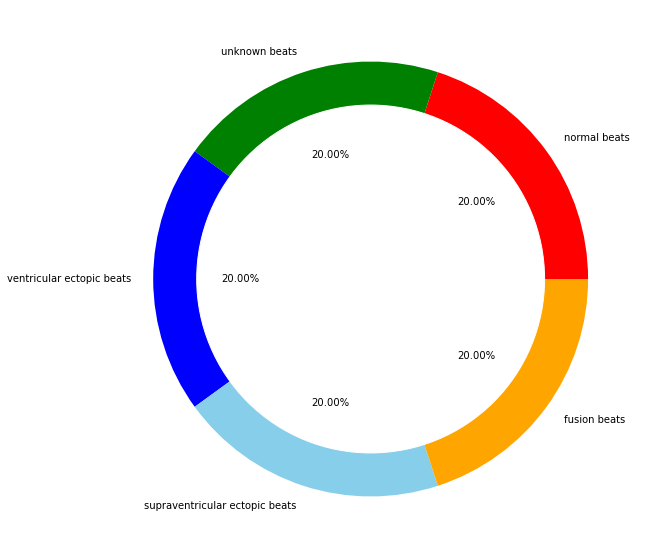

In [6]:
per_class=df_train[187].value_counts()
plt.figure(figsize=(20,10))
circle=plt.Circle( (0,0), 0.8, color='white')
cmap=plt.get_cmap("tab20c")
plt.pie(per_class, labels=['normal beats','unknown beats','ventricular ectopic beats','supraventricular ectopic beats',
                           'fusion beats'], colors=['red','green','blue','skyblue','orange'],autopct='%.2f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.show()

In [7]:
classes=df_train.groupby(187,group_keys=False).apply(lambda train:train.sample(1))
categories=["Normal beat","Unknown beats","Ventricular Ectopic beats","Supraventricular Ectopic beats","Fusion beats"]

## Addition of Gaussian noise for a more realistic approach

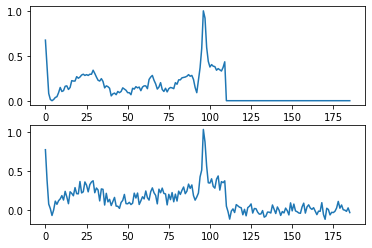

In [8]:
def gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return(signal+noise)
temp=classes.iloc[0, :186]
bruiter=gaussian_noise(temp)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0, :186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

## CNN Model

In [9]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.layers.normalization import BatchNormalization

In [10]:
def network(x_train,y_train,x_test,y_test):
    

    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='MODEL_TF.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(x_train, y_train,epochs=30,callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('MODEL_TF.h5')
    return(model,history)

In [11]:
def evaluate_model(history,x_test,y_test,model):
    scores = model.evaluate((x_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(x_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [15]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
target_train=df_train[187]
target_test=df_test[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
x_train=df_train.iloc[:,:186].values
x_test=df_test.iloc[:,:186].values
x_train_cnn=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test_cnn=x_test.reshape(len(x_test),x_test.shape[1],1)


model,history=network(x_train,y_train,x_test,y_test)

Epoch 1/30
3125/3125 [==============================] - 116s 36ms/step - loss: 0.1915 - accuracy: 0.9318 - val_loss: 0.1843 - val_accuracy: 0.9394
Epoch 2/30
3125/3125 [==============================] - 110s 35ms/step - loss: 0.0758 - accuracy: 0.9735 - val_loss: 0.1542 - val_accuracy: 0.9530
Epoch 3/30
3125/3125 [==============================] - 109s 35ms/step - loss: 0.0488 - accuracy: 0.9836 - val_loss: 0.1321 - val_accuracy: 0.9613
Epoch 4/30
3125/3125 [==============================] - 124s 40ms/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 0.1529 - val_accuracy: 0.9571
Epoch 5/30
3125/3125 [==============================] - 107s 34ms/step - loss: 0.0298 - accuracy: 0.9900 - val_loss: 0.1091 - val_accuracy: 0.9802
Epoch 6/30
3125/3125 [==============================] - 107s 34ms/step - loss: 0.0253 - accuracy: 0.9920 - val_loss: 0.1459 - val_accuracy: 0.9647
Epoch 7/30
3125/3125 [==============================] - 109s 35ms/step - loss: 0.0220 - accuracy: 0.9932 - val_loss: 0

In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn (InputLayer)     [(None, 186, 1)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 181, 64)           448       
                                                                 
 batch_normalization_3 (Batc  (None, 181, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 91, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 89, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 89, 64)           256 

Accuracy: 98.02%


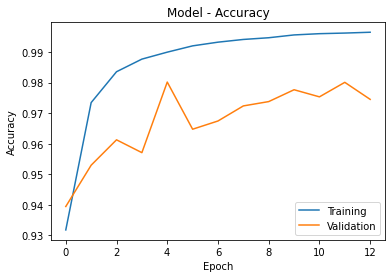

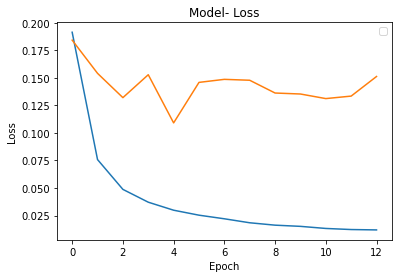

685/685 [==============================] - 7s 10ms/step


In [17]:
evaluate_model(history,x_test,y_test,model)
y_pred=model.predict(x_test)

### Confusion Matrix

Normalized confusion matrix


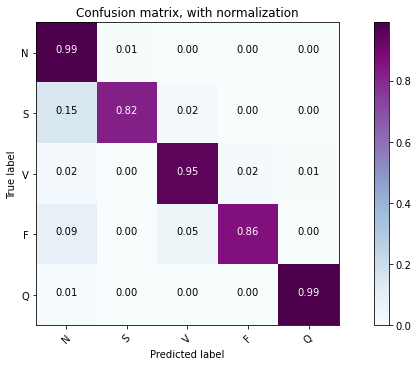

In [29]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 5))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

### Mean Squared Error (loss)

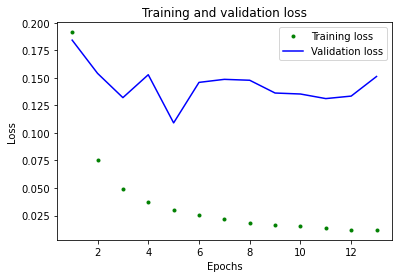

In [19]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Mean Absolute Error

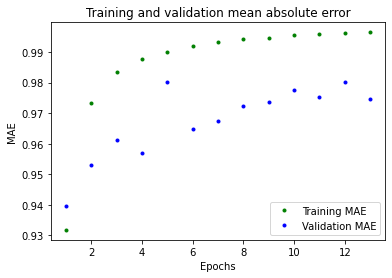

In [20]:
SKIP=0
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['accuracy']
val_mae = history.history['val_accuracy']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

### Actual v/s Predicted values

Accuracy: 98.02%


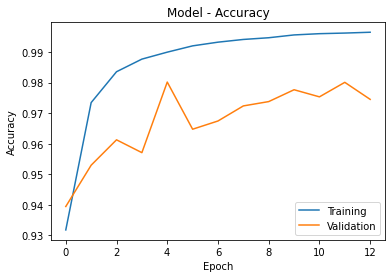

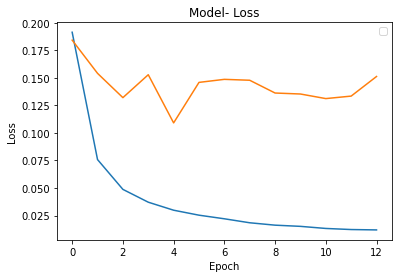

685/685 [==============================] - 7s 11ms/step


In [21]:
evaluate_model(history,x_test,y_test,model)
y_pred=model.predict(x_test)

## Convert Keras model to TFLite model

In [ ]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
tflite_model_name = "heartBeatTF"
open( tflite_model_name + '.tflite', 'wb').write(tflite_model)

## Convert to C code

In [ ]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

In [ ]:
# Write TFLite model to a C source (or header) file
c_model_name=tflite_model_name
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))
     